# Analysing the models and the SVC algorithm over the test set

In [358]:
# Import modules
from sample_methods import *
from NN_methods import *
import matplotlib.pyplot as plt
import torch
import pandas as pd
import seaborn as sns

# Analysing the results on the test set

## Predictions of the GNNs models on the testset (Runtime ~ 1h)

In [293]:
# Define parameters for device, models and optimizers 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

SAGE1_model = GraphSAGE(hidden_channels=64).to(device)
SAGE1_opti =  torch.optim.Adam(SAGE1_model.parameters(), lr=1e-3, eps = 1e-7)

SAGE2_model = GraphSAGE(hidden_channels=64).to(device)
SAGE2_opti =  torch.optim.Adam(SAGE2_model.parameters(), lr=5e-4, eps = 1e-7)

SIMPLE_model = Simple_GCN(hidden_channels=64).to(device)
SIMPLE_opti =  torch.optim.Adam(SIMPLE_model.parameters(), lr=1e-3, eps = 1e-7)

GCN_model = GCN(hidden_channels=64).to(device)
GCN_opti =  torch.optim.Adam(GCN_model.parameters(), lr=1e-3, eps = 1e-7)

# Load trained models
# 1. Load GraphSAGE model trained over 13 epochs  
SAGE1_model, SAGE1_opti, epoch = load_checkpoint(SAGE1_model, SAGE1_opti, device, 'History/checkpoint20221215-130715.pt')

# 2. Load GraphSAGE model trained over 25 epochs  
SAGE2_model, SAGE2_opti, epoch = load_checkpoint(SAGE2_model, SAGE2_opti, device, 'History/checkpoint20221220-051712.pt')

# 3. Load GCN with 1 hidden layer model trained over 13 epochs  
SIMPLE_model, SIMPLE_opti, epoch = load_checkpoint(SIMPLE_model, SIMPLE_opti, device, 'History/checkpoint20221220-084748.pt')

# 4. Load GCN model with 3 hidden layers trained over 13 epochs  
GCN_model, GCN_opti, epoch = load_checkpoint(GCN_model, GCN_opti, device, 'History/checkpoint20221220-064745.pt')

models = [SAGE1_model, SAGE2_model, SIMPLE_model, GCN_model]
optis = [SAGE1_opti, SAGE2_opti, SIMPLE_opti, GCN_opti]

# Load the test dataset
testset = Circles_Dataset(root='Data/testset')


In [156]:
# Create a function to make prediction using a certain model
def make_predicion(test_set):

    for model in models:
        model.eval()
    
    preds_dict = {
    "preds_SAGE1": np.array([]),
    "preds_SAGE2": np.array([]),
    "preds_SIMPLE": np.array([]),
    "preds_GCN": np.array([])
    }

    labels = np.array([])
    with torch.no_grad():
        for data in tqdm(test_set):
            data = data.to(device)
            i = 0
            for key, preds in preds_dict.items():
                model = models[i]
                preds_dict[key] = np.append(preds, model(data)[:,0].numpy())
                i += 1
      
            labels = np.append(labels, data.y.numpy())

    return preds_dict, labels

In [ ]:
# Make prediction over the test set using the trained model (~ about 1h)
preds, labels = make_predicion(testset)

# Put all the predictions and their absolute error into a panda dataframe
df_dict = dict({"labels":labels}, **preds)
df = pd.DataFrame.from_dict(df_dict)

abs_error = {
    "err_" + k: np.abs(labels - v) for k,v in preds.items()
}

df_err = pd.DataFrame.from_dict(abs_error)

df = df.join(df_err)

# Save this dataframe into a pickle file
df.to_pickle('Data/Analysis_of_results/Models_test')

## Predictions of the OpenCV algorithm on the testset (Runtime ~3h)

In [6]:
# import necessary modules
from scipy.spatial.distance import cdist
import cv2 as cv

# Load the testset containing 25 000 samples
testset = Circles_Dataset(root='Data/testset')

In [258]:
def cv_contour_estimate(nb_points_per_angle, max_radius, points, cmap = 'viridis'):
    '''Function to compute the area a beam using cv contour. 
    nb_points_per_angle = nb of points per angle
    '''

    # Create a meshgrid
    angles = np.radians(np.linspace(0, 90, 13))

    radius = np.linspace(1e-3, max_radius, nb_points_per_angle)
    r, theta = np.meshgrid(radius, angles)
    x_mesh,y_mesh = r*np.cos(theta), r*np.sin(theta)

    # Flatten the meshgrid in order to have a array of coordinates
    mesh_flat = np.hstack((x_mesh.flatten()[:, np.newaxis],y_mesh.flatten()[:, np.newaxis]))

    # Compute the euclidian distance element wise between the meshgrid and the sample
    dist = cdist(mesh_flat, points)

    # Reconstruct the beam on the meshgrid: if the distance is less than the density/2, then put 1 and 0 else
    mask = (dist < max_radius/(2*nb_points_per_angle))
    mask = np.amax(mask, axis = 1)

    # Approximate the angle 0 (resp. 90) to be the same amplitude as 7.5 (resp. 82.5)
    mask[:nb_points_per_angle] = mask[2*nb_points_per_angle:3*nb_points_per_angle]
    mask[12*nb_points_per_angle:] = mask[11*nb_points_per_angle:12*nb_points_per_angle]

    # Image of the beam on the meshgrid to plot the contour
    global Z
    Z = mask.reshape(13,nb_points_per_angle).astype(int)
    
    # Extract the contour array from the matplotlib function contourf
    contour_plot = plt.contourf(x_mesh, y_mesh, Z, cmap = cmap)
    path    = contour_plot.collections[6].get_paths()[0].vertices
    contour = np.float32(path)

    # Compute the area with OpenCv
    area = cv.contourArea(contour)

    return 4*area, contour

def make_predicion_cv(nb_points_per_angle, max_radius, dataset):
    areas_computed = []
    labels = np.array([])
    for i in tqdm(range(len(dataset))):
        # Remove the normalization
        points = dataset[i].x.numpy()*15
        area, _ = cv_contour_estimate(nb_points_per_angle, max_radius, points)
        areas_computed.append(area)
        labels = np.append(labels, dataset[i].y.numpy())
    return np.array(areas_computed)/(15*15*4), labels #Apply the normalization

In [ ]:
# Make prediction with OpenCV algo over the full test set (about 4h of runtime)
predictions, labels = make_predicion_cv(100, 16, testset)

# Save into a pickle file 
(pd.DataFrame(data = {"labels":labels, "preds_CV":predictions})).to_pickle("Data/Analysis_of_results/CV_preds_25k.pkl")

## Comparison between GNNs models and OpenCV algorithm

In [356]:
# Read predictions on the testset of GNNs models
df1 = pd.read_pickle('Data/Analysis_of_results/GNNs_preds_testset.pkl')

# Read predictions on the testset of OpenCV algo
df2 = pd.read_pickle('Data/Analysis_of_results/CV_preds_testset.pkl')

# Merge the dataframes
df = df1.join(df2, rsuffix= '_1').drop('labels_1', axis = 1)

df

,labels,preds_SAGE1,preds_SAGE2,preds_SIMPLE,preds_GCN,err_preds_SAGE1,err_preds_SAGE2,err_preds_SIMPLE,err_preds_GCN,preds_CV,err_preds_OpenCV
0,0.201916,0.210318,0.203562,0.208214,0.212703,0.008402,0.001646,0.006299,0.010787,0.201715,0.000201
1,0.147634,0.138933,0.136274,0.130235,0.136643,0.008701,0.011360,0.017399,0.010991,0.146219,0.001415
2,0.104926,0.097113,0.093867,0.093707,0.094558,0.007813,0.011058,0.011218,0.010367,0.105300,0.000374
3,0.423785,0.432703,0.435735,0.437822,0.436370,0.008917,0.011950,0.014037,0.012585,0.415305,0.008480
4,0.084441,0.077280,0.072649,0.078677,0.073751,0.007161,0.011793,0.005764,0.010690,0.082394,0.002048
...,...,...,...,...,...,...,...,...,...,...,...
24995,0.148390,0.137517,0.135690,0.133213,0.134487,0.010873,0.012700,0.015177,0.013903,0.143502,0.004888
24996,0.326371,0.316346,0.318795,0.314989,0.321379,0.010025,0.007576,0.011382,0.004991,0.328413,0.002042
24997,0.614738,0.611583,0.613404,0.619982,0.622160,0.003155,0.001333,0.005244,0.007422,0.612821,0.001917
24998,0.489849,0.493534,0.500336,0.492958,0.501653,0.003684,0.010487,0.003109,0.011803,0.487363,0.002486


In [ ]:
# Add category of sample to the dataframe to explore the weaknesses of each models
df['category'] = 'Na'
df.iloc[0:5000, 11] = 'ellipse'
df.iloc[5000:10000, 11] = '1circle'
df.iloc[10000:15000, 11] = '2circles'
df.iloc[15000:20000, 11] = 'truncated1'
df.iloc[20000:25000, 11] = 'truncated2'

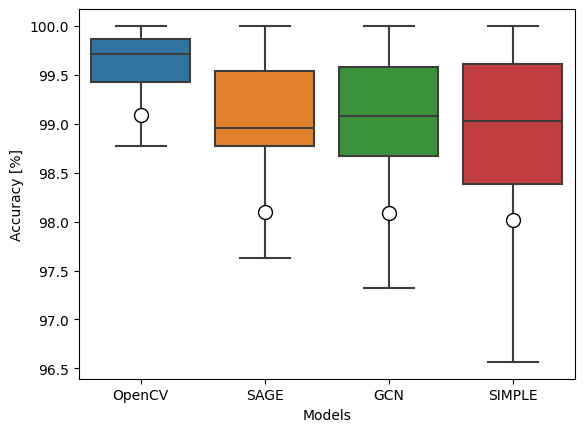

In [362]:
# Prepare data to plot them
df_temp = df.rename(columns={'err_preds_OpenCV':'OpenCV', 'err_preds_SAGE2':'SAGE', 'err_preds_GCN':'GCN', 'err_preds_SIMPLE':'SIMPLE'})
dfm = df_temp[['OpenCV', 'SAGE', 'GCN', 'SIMPLE', 'category']].melt('category', var_name='cols', value_name='vals')

# Convert absolute error into accuracy score
dfm['vals'] = (1 - dfm['vals'])*100

# Boxplots of the studied models
sns.boxplot(data = dfm, y = 'vals', x = 'cols', showfliers = False, showmeans=True, meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"})
plt.ylabel('Accuracy [%]')
plt.xlabel('Models')
plt.show()

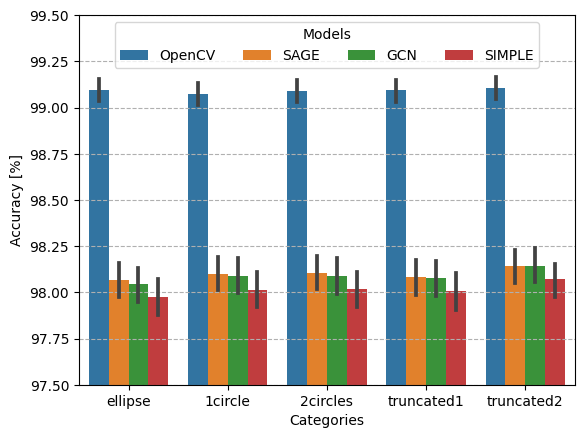

In [363]:
# Plot the accuracy of each model regarding the category of DAs evaluated
sns.barplot(data=dfm, x="category", y="vals", hue = 'cols')
plt.ylim([97.5, 99.5])
plt.xlabel('Categories')
plt.ylabel('Accuracy [%]')
plt.legend(title = 'Models', loc = 'upper center', ncol=4)
plt.grid(which = 'both', axis = 'y', linestyle = '--')
plt.show()

# Analysing the results on the dataset of real CERN DAs


## Make predictions with the GNNs models and OpenCV algo

In [10]:
# Create a function to make prediction using a certain model
def make_predicion_SAGE(test_set, model):
    print('Predicting')
    model.eval()
    
    preds = np.array([])
    labels = np.array([])

    with torch.no_grad():
        for data in tqdm(test_set):
            data = data.to(device)
            preds = np.append(preds, model(data)[:,0].numpy())
            labels = np.append(labels, data.y.numpy())

    return preds, labels

In [368]:
# Create a dataset with all the CERN DAs value keeping all the particles with have made more than 10 000 turns
DA_dataset = Circles_Dataset('Data/CERN_DAs/')

# Make prediction using CV algorithm
print('Predicting with CV contour...')
preds_DA_CV = make_predicion_cv(100, 25, DA_dataset)

# Make prediction using SAGE model
print('Predictiong using SAGE conv model')
preds, _ = make_predicion(DA_dataset)

# Gather predictions into a dataframe
df_DA = pd.DataFrame(data = {'preds_CV':preds_DA_CV, **preds})

# Normalize predictions 
for col in df_DA.columns.to_list():
    df_DA[col] = (df_DA[col] - df_DA[col].min()) / (df_DA[col].max() - df_DA[col].min())

# Compute the absolute error between OpenCV predictions and GNNs models
df_DA["err_SAGE1"] = np.abs(df_DA.preds_CV.to_numpy()-df_DA.preds_SAGE1.to_numpy())
df_DA["err_SAGE2"] = np.abs(df_DA.preds_CV.to_numpy()-df_DA.preds_SAGE2.to_numpy())
df_DA["err_SIMPLE"] = np.abs(df_DA.preds_CV.to_numpy()-df_DA.preds_SIMPLE.to_numpy())
df_DA["err_GCN"] = np.abs(df_DA.preds_CV.to_numpy()-df_DA.preds_GCN.to_numpy())

plt.close()
df_DA.head()

Predicting with CV contour...


100%|██████████| 100/100 [00:29<00:00,  3.45it/s]


Predictiong using SAGE conv model
Predicting


100%|██████████| 100/100 [00:33<00:00,  2.98it/s]


,preds_CV,preds_SAGE1,preds_SAGE2,preds_SIMPLE,preds_GCN,err_SAGE1,err_SAGE2,err_SIMPLE,err_GCN
0,0.785265,0.794314,0.683675,0.781602,0.746396,0.009049,0.101590,0.003663,0.038869
1,0.673053,0.727991,0.618893,0.645882,0.586870,0.054938,0.054160,0.027171,0.086183
2,0.515589,0.569841,0.477544,0.471551,0.382741,0.054252,0.038045,0.044038,0.132848
3,0.796845,0.684312,0.572174,0.695607,0.619975,0.112533,0.224672,0.101238,0.176870
4,0.655196,1.000000,0.946027,0.246028,0.289321,0.344804,0.290831,0.409168,0.365875


Text(0, 0.5, 'Accuracy [%]')

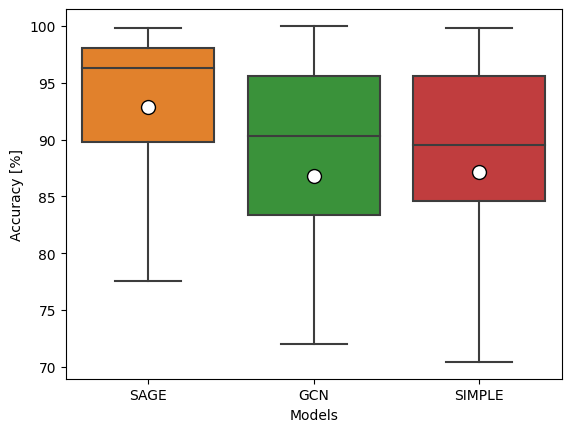

In [369]:
# Convert absolute error into accuracy
df_DA = (1- df_DA)*100

# Change name for plot display
df_DA.rename(columns={'err_SAGE2':'SAGE', 'err_GCN':'GCN', 'err_SIMPLE':'SIMPLE'}, inplace = True)

# Boxplot of models accuracy evaluated on real DAs
sns.boxplot(data=df_DA[['SAGE', 'GCN', 'SIMPLE']], showfliers = False, palette=sns.color_palette()[1:], showmeans=True, meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"})
plt.xlabel('Models')
plt.ylabel('Accuracy [%]')